# Proyecto Final del curso de Reconocimiento de Patrones
### Maestría en Electrónica del TEC
### Autor: Pamela Salazar Espinoza

Este cuaderno corresponde al proyecto del curso de reconocimiento de patrones del TEC. El reconocimiento de voz o reconocimiento del habla es una rama de la inteligencia artificial cuya finalidad es posibilitar la comunicación entre humanos y sistemas informáticos. Un sistema de reconocimiento de voz tiene la capacidad de detectar y entender las palabras que un ser humano emite de forma natural. En un esfuerzo por entrenar estos sistemas se han creado diferentes bases de datos en distintos idiomas, con diferentes de acentos por ejemplo la enconteada en: 

https://commonvoice.mozilla.org/es/datasets

El objetivo de este proyecto es entrenar una red neuronal para reconocer algunas palabras dichas utilizando el acento costarricense. Para ello se uso los siguientes audios:

https://www.youtube.com/watch?v=SipemIJjg-E

Para recortar el audio en palabras se uso la herramienta:

https://mp3cut.net/es/

In [1]:
##Importar librerias necesarias

import os
import pandas as pd
import numpy as np
import random
import pickle
import seaborn as sns
import librosa
import pickle
import matplotlib.pyplot as plt
import librosa.display
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.optimizers import Adam
import  np_utils
from tensorflow.keras  import metrics 
from keras.losses import CategoricalCrossentropy
from sklearn import model_selection

C:\Users\psalazar\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### 1. Limpieza de datos

1. Crear una tabla de los archivos con sus respectivas carpetas

In [2]:
contenido = os.listdir('.\dataset\palabras')
archvos_list = []
carpeta_list = []
carpeta_list1 = []
for carpeta in contenido:
    archivos = os.listdir('.\dataset\palabras\\' + carpeta)
    carpeta_list1.append(carpeta)
    for archivo in archivos:
        archvos_list.append(archivo)
        carpeta_list.append(carpeta)

df = pd.DataFrame()
df['Carpeta']  = carpeta_list
df['Archivos'] = archvos_list 
df

,Carpeta,Archivos
0,acompanarlo,acompanarlo1.m4a
1,actividades,audio1 (mp3cut.net) - 2024-03-28T130319.780.m4a
2,adecuada,adecuada1.m4a
3,ambiente,audio1 (mp3cut.net) (76).m4a
4,aqui,aqui1.m4a
...,...,...
349,vecinos,audio1 (mp3cut.net) (93).m4a
350,vecinos,audio1 (mp3cut.net) - 2024-03-28T130351.337.m4a
351,vehiculos,audio1 (mp3cut.net) (89).m4a
352,vida,vida1.m4a


2. Clasificar las muestras.

In [3]:
clases_list = []
clasesID_list = []
for carpeta in df['Carpeta']:
    if carpeta == 'cancer':
        clase = 'cancer'
        id = 0
    elif carpeta == 'tiempo':
        clase = 'tiempo'
        id = 1
    elif carpeta == 'diagnostico':
        clase = 'diagnostico'
        id = 2
    elif carpeta == 'pacientes':
        clase = 'pacientes'
        id = 3
    else:
        clase = 'desconocido'
        id = 4
    clases_list.append(clase)
    clasesID_list.append(id)
df['Clase'] = clases_list
df['Clase ID'] = clasesID_list

df.drop(df[(df['Clase'] == 'desconocido')].index, inplace=True)
df

,Carpeta,Archivos,Clase,Clase ID
20,cancer,cancer1.mp3,cancer,0
21,cancer,cancer10.mp3,cancer,0
22,cancer,cancer11.mp3,cancer,0
23,cancer,cancer12.mp3,cancer,0
24,cancer,cancer13.mp3,cancer,0
...,...,...,...,...
324,tiempo,tiempo5.mp3,tiempo,1
325,tiempo,tiempo6.mp3,tiempo,1
326,tiempo,tiempo7.mp3,tiempo,1
327,tiempo,tiempo8.mp3,tiempo,1


3. Dividir datos de entrenamineto y validacion.

In [4]:
from sklearn.model_selection import train_test_split

Usar el 20% de os datos de clase "cancer" para validacion

In [5]:
df1 = df[df['Clase']=='cancer'].reset_index()
df1 = df1.drop(['index'],axis=1)
train_cancer, test_cancer = train_test_split(df1, test_size = 0.20, shuffle = False)

Usar el 20% de os datos de clase "diagnostico" para validacion

In [6]:
df1 = df[df['Clase']=='diagnostico'].reset_index()
df1 = df1.drop(['index'],axis=1)
train_diagnostico, test_diagnostico = train_test_split(df1, test_size = 0.20, shuffle = False)

Usar el 20% de os datos de clase "pacientes" para validacion

In [7]:
df1 = df[df['Clase']=='pacientes'].reset_index()
df1 = df1.drop(['index'],axis=1)
train_pacientes, test_pacientes = train_test_split(df1, test_size = 0.20, shuffle = False)

Usar el 20% de los datos de clase "tiempo" para validacion

In [8]:
df1 = df[df['Clase']=='tiempo'].reset_index()
df1 = df1.drop(['index'],axis=1)
train_tiempo, test_tiempo = train_test_split(df1, test_size = 0.20, shuffle = False)

Crear dataset de entrenamiento

In [9]:
train = pd.concat([train_cancer, train_diagnostico,train_pacientes,train_tiempo], axis=0)
train['Group'] = 'Train'

Crear dataset de prueba

In [10]:
test = pd.concat([test_cancer, test_diagnostico,test_pacientes,test_tiempo], axis=0)
test['Group'] = 'Test'

Visualizar datos entrenamiento y datos de prueba

In [11]:
df = pd.concat([train,test], axis=0).reset_index()
df = df.drop(['index'],axis=1)
df

,Carpeta,Archivos,Clase,Clase ID,Group
0,cancer,cancer1.mp3,cancer,0,Train
1,cancer,cancer10.mp3,cancer,0,Train
2,cancer,cancer11.mp3,cancer,0,Train
3,cancer,cancer12.mp3,cancer,0,Train
4,cancer,cancer13.mp3,cancer,0,Train
...,...,...,...,...,...
86,tiempo,tiempo5.mp3,tiempo,1,Test
87,tiempo,tiempo6.mp3,tiempo,1,Test
88,tiempo,tiempo7.mp3,tiempo,1,Test
89,tiempo,tiempo8.mp3,tiempo,1,Test


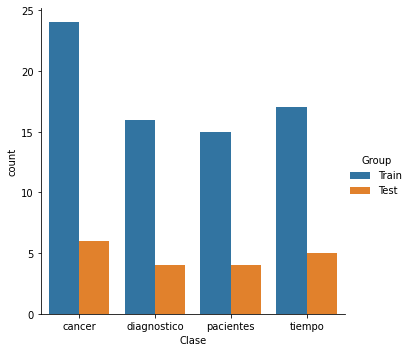

In [12]:
sns.catplot(data=df,kind='count',x='Clase',hue='Group')

3. Crear espectogramas
Nota, para crear los espectogramas hay que cambiar el formato del archivo a mp3.

In [13]:
def spectogram (audio_file):
    fs = 16000
    y, sr = librosa.load(audio_file, sr = 16000)
    if len(y) < fs:
       y = np.concatenate((y,np.zeros((fs-len(y)),dtype='int')))
    elif len(y) > fs:
        y = y[:fs]
    S = librosa.feature.melspectrogram(y=y, sr=fs, n_mels=40,n_fft =  25*fs//1000, win_length = 25*fs//1000, hop_length = 10*fs//1000, center=True,
        power=2)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

En la siguiente celda se guarda el espectograma de cada archivo de audio en un archivo dentro de la carpeta 'espectogramas'. 

In [14]:
for i in range(len(df['Archivos'])):
    file = df['Archivos'][i]
    carpeta = df['Carpeta'][i]
    path_audio = 'dataset\palabras\\' + carpeta +  '\\' + file
    name, extension = file.split('.')
    file_name = carpeta +  '_' +  name + '.pickle'
    S_dB = spectogram (path_audio)   
    path = 'espectogramas/'+ file_name
    with open(path, "wb") as f:
        pickle.dump(S_dB, f)

c:\Users\psalazar\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


4. Entrenar la red neuronal.